In [1]:
from __future__ import division, absolute_import

import os
import sys
import random

import numpy as np
import datetime

#root
absPath = '/home/angela/padding_EBI/'
sys.path.insert(0, absPath)

#from src.Target import Target

np.random.seed(8)
random.seed(8)

from src.preprocessing import *
from src.model_architecture import *
from src.training_model import *
from src.postprocessing import *
from src.comparing_results import *
#from src.callbacks import *
%matplotlib inline

Using TensorFlow backend.


In [7]:
list_paddings = ["aug_padding"]
#folder = "prueba"
column = "EC number"

n_folds = 1

dicti = creating_dict()

max_lenn = 1000

n_class = 2 #number of classes to output
drop_per = 0.2 #Input dropout 
n_neur = [314,77, 8]
drop_hid = 0.5
dict_size = len(dicti)
final_act = "softmax"
n_filt = 64 #None
kernel_size = [5] #None
pool_size = None

batch_size = 54
epochss = 50

callbacks_list = [None, None, None, None, False, False, False, False]
task = "task1/"
#architecture = "only_denses"
architecture = "conv_dense"

In [8]:
lr=0.0001

optimizer = Adam(lr=lr)

In [9]:
folder = 'EC_number/archaea/1conv/64filts_size5/'

file_idcs_aug = os.path.join(absPath, 'data/', folder, 'idcs_aug_split.pickle')

with open(file_idcs_aug, "rb") as input_file:
    k_aug_indices = pickle.load(input_file)
    
file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_split.pickle')

with open(file_idcs, "rb") as input_file:
    splitting_sets = pickle.load(input_file)

In [10]:
#model = building_3dense_model_task1(max_lenn, dict_size, n_neur, n_class, drop_per, drop_hid, 'softmax', folder)
model = building_1convdense_model_task1(max_lenn, dict_size, n_neur, n_class, drop_per, drop_hid, n_filt, kernel_size, final_act, folder, optimizer)

generators_dict = {} 
for model_type in list_paddings:
    generators_dict[model_type] = trainval_generators(splitting_sets, k_aug_indices, model_type, 
                                                      folder, batch_size, 'labels_task1', True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000, 26)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000, 26)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 64)          8384      
_________________________________________________________________
dense_9 (Dense)              (None, 1000, 314)         20410     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1000, 314)         0         
_________________________________________________________________
dense_10 (Dense)             (None, 1000, 77)          24255     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1000, 77)          0         
__________

In [20]:
def model_training(model_type, folder, task, idx, callbacks_list, train_generator, val_generator,
                   architecture, max_len, dict_size, batch_size,
                  n_neur, n_class, drop_per, drop_hid, final_act, epochss, 
                   len_train, len_val, n_filt = None, 
                   kernel_size=None, pool_size=None, nhid=None, optimizer=Adam()):
    """Training model"""
    folder_cp = ''.join(string for string in [folder, task, model_type, '/', str(idx)])
    if not os.path.exists(os.path.join(absPath, 'data/checkpoint/', folder_cp)):
        os.makedirs(''.join(string for string in [absPath, 'data/checkpoint/', folder_cp]))
    callbacks_list = calling_callbacks(folder_cp, folder, model_type, callbacks_list[0], callbacks_list[1], 
                                        callbacks_list[2], callbacks_list[3], callbacks_list[4], 
                                        callbacks_list[5], callbacks_list[6], callbacks_list[7])
    folder_task =  ''.join(string for string in [folder, task])
    #deberia haber aqui muchos ifs para elegir el tipo de modelo
    model = model_choice(architecture, task, folder, max_len, dict_size, n_neur, n_class, drop_per, drop_hid, 
                            final_act, n_filt=n_filt, kernel_size=kernel_size, pool_size=pool_size, 
                         nhid = nhid, optimizer=optimizer)
    #writing log file 
    log_file = ''.join(string for string in [absPath, 'data/checkpoint/', folder, task, 'log_file.txt' ]) 
    f = open(log_file, 'a+')
    print('Model type: %s \n' % model_type, file=f)
    print('Fold: %i \n' % idx, file=f)
    start = time.time()
    formatted_time = datetime.datetime.now()
    print('Starting time: %s \n' % formatted_time, file=f)
    history = model.fit_generator(generator=train_generator, 
                            validation_data=val_generator,
                            steps_per_epoch= int(len_train/batch_size),
                            validation_steps=int(len_val/batch_size),
                            epochs=epochss,
                            callbacks=callbacks_list,
                            verbose=1)
    #end = time.time()
    #formatted_endtime = datetime.datetime.now()
    #print('Finishing time: %s \n' % formatted_endtime, file=f)
    #count_time(start, end, folder, model_type)
    #saving_results(history, model_type, folder, task, idx, True)
    #f.close()
    return history

In [21]:
folder = 'prueba/'
for model_type in list_paddings:
    generators = generators_dict[model_type]
    for idx,i in enumerate(generators[:1]):
        if model_type == "aug_padding":
            i_train, i_val, i_test = k_aug_indices[idx]
        else: 
            i_train, i_val, i_test = splitting_sets[idx]
        len_train, len_val, len_test = len(i_train), len(i_val), len(i_test)
        train_generator, val_generator = i
        history = model_training(model_type, folder, task, idx, callbacks_list, train_generator, val_generator,
                        architecture, max_lenn, dict_size, batch_size,
                        n_neur, n_class, drop_per, drop_hid, final_act, epochss, 
                        len_train, len_val, 
                        n_filt = n_filt, kernel_size=kernel_size, pool_size=pool_size,
                                 nhid=None,
                      optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 1000, 26)          0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 1000, 26)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1000, 64)          8384      
_________________________________________________________________
dense_53 (Dense)             (None, 1000, 314)         20410     
_________________________________________________________________
dropout_54 (Dropout)         (None, 1000, 314)         0         
_________________________________________________________________
dense_54 (Dense)             (None, 1000, 77)          24255     
_________________________________________________________________
dropout_55 (Dropout)         (None, 1000, 77)          0         
__________

1758/1758 [==============================] - 50s 29ms/step - loss: 0.5381 - acc: 0.7468 - val_loss: 0.5967 - val_acc: 0.7544

Epoch 00028: val_acc improved from 0.75266 to 0.75438, saving model to /home/angela/padding_EBI/data/checkpoint/prueba/task1/aug_padding/0/weights-improvement-028-0.7544.hdf5
Epoch 29/50
1758/1758 [==============================] - 51s 29ms/step - loss: 0.5368 - acc: 0.7472 - val_loss: 0.5938 - val_acc: 0.7570

Epoch 00029: val_acc improved from 0.75438 to 0.75704, saving model to /home/angela/padding_EBI/data/checkpoint/prueba/task1/aug_padding/0/weights-improvement-029-0.7570.hdf5
Epoch 30/50
1758/1758 [==============================] - 50s 29ms/step - loss: 0.5353 - acc: 0.7485 - val_loss: 0.5914 - val_acc: 0.7617

Epoch 00030: val_acc improved from 0.75704 to 0.76172, saving model to /home/angela/padding_EBI/data/checkpoint/prueba/task1/aug_padding/0/weights-improvement-030-0.7617.hdf5
Epoch 31/50
1758/1758 [==============================] - 50s 29ms/step - 

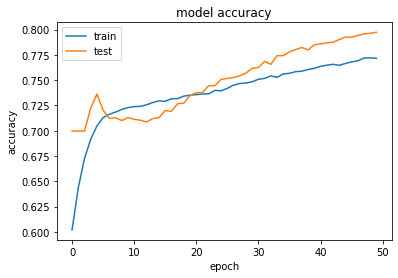

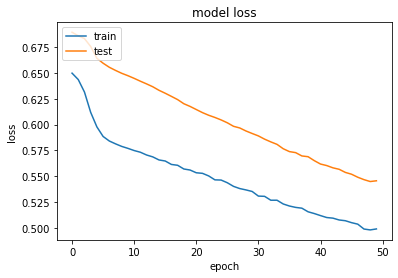

In [22]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def building_convrnn_model_task1(max_len, dict_size, number_neurons, n_class, drop_per, drop_hid, 
                                 n_filt, kernel_size, pool_size, nhid, final_act, folder, optimizer=Adam()):
    """"Builds a model with a convolutional layer and three Dense layers whose number of neurons are specified in decreasing order in number_neurons"""
    input_seq = Input(shape=(max_len, dict_size), dtype='float32')
    dropout_seq = Dropout(drop_per)(input_seq)
    
    c1 = Conv1D(filters=n_filt, kernel_size=kernel_size, padding='same', strides=1, activation='relu')(dropout_seq)
    pooled = MaxPooling1D(pool_size=pool_size, strides=None, padding='same')(c1)
    
    dropout_2 = Dropout(drop_hid)(pooled)
    
    bilstm_seq = Bidirectional(LSTM(n_hid, dropout=drop_hid, recurrent_dropout=drop_hid, activation='tanh'), merge_mode='concat')(dropout_2)
    
    #main_dense = Dense(n_class, activation=final_act)(bilstm_seq)
    #model = Model(inputs=[input_seq], outputs=[main_dense])
    
    #Denses
    dense_seq1 = Dense(number_neurons[0], activation='relu')(bilstm_seq)
    dropout_seq1 = Dropout(drop_hid)(dense_seq1)
    dense_seq2 = Dense(number_neurons[1], activation='relu')(dropout_seq1)
    dropout_seq2 = Dropout(drop_hid)(dense_seq2)
    dense_seq3 = Dense(number_neurons[2], activation='relu')(dropout_seq2)
    dropout_seq3 = Dropout(drop_hid)(dense_seq3)
    flatten = Flatten()(dropout_seq3)
    main_dense = Dense(n_class, activation=final_act)(flatten)
    model = Model(inputs=[input_seq], outputs=[main_dense])
    print(model.summary())
    
    #adamm = Adam()
    adamm = optimizer
    model.compile(loss='categorical_crossentropy', optimizer = adamm, metrics=['accuracy'])
    
    # saving the model
    file_model = os.path.join(absPath, 'data/', folder, 'model.h5')

    model.save(file_model)
    return model

In [ ]:
def building_convrnn_model_task2(max_len, dict_size, number_neurons, n_class, drop_per, drop_hid, 
                                 n_filt, kernel_size, pool_size, nhid, final_act, folder, optimizer=Adam()):
    """"Builds a model with a convolutional layer and three Dense layers whose number of neurons are specified in decreasing order in number_neurons"""
    input_seq = Input(shape=(max_len, dict_size), dtype='float32')
    dropout_seq = Dropout(drop_per)(input_seq)
    
    c1 = Conv1D(filters=n_filt, kernel_size=kernel_size, padding='same', strides=1, activation='relu')(dropout_seq)
    pooled = MaxPooling1D(pool_size=pool_size, strides=None, padding='same')(c1)
    
    dropout_2 = Dropout(drop_hid)(pooled)
    
    bilstm_seq = Bidirectional(LSTM(n_hid, dropout=drop_hid, recurrent_dropout=drop_hid, activation='tanh'), merge_mode='concat')(dropout_2)
    
    #main_dense = Dense(n_class, activation=final_act)(bilstm_seq)
    #model = Model(inputs=[input_seq], outputs=[main_dense])
    
    #Denses
    dense_seq1 = Dense(number_neurons[0], activation='relu')(bilstm_seq)
    dropout_seq1 = Dropout(drop_hid)(dense_seq1)
    dense_seq2 = Dense(number_neurons[1], activation='relu')(dropout_seq1)
    dropout_seq2 = Dropout(drop_hid)(dense_seq2)
    flattenn = Flatten()(dropout_seq2)
    main_dense = Dense(n_class, activation=final_act)(flattenn)
    model = Model(inputs=[input_seq], outputs=[main_dense])
    print(model.summary())
    
    #adamm = Adam()
    adamm = optimizer
    model.compile(loss='categorical_crossentropy', optimizer = adamm, metrics=['accuracy'])
    
    # saving the model
    file_model = os.path.join(absPath, 'data/', folder, 'model.h5')

    model.save(file_model)
    return model

In [19]:
def model_choice(architecture, task, folder, max_len, dict_size, n_neur, n_class, drop_per, drop_hid, final_act, 
                 n_filt=None, kernel_size=None, pool_size=None, nhid=None, optimizer=Adam()):
    """Choosing model architecture and defining model"""
    if architecture == "only_denses":
        if task == "task1/":
            model = building_2dense_model_task1(max_len, dict_size, n_neur, n_class, drop_per,
                                                drop_hid, final_act, folder, optimizer)
        else:
            model = building_2dense_model_task2(max_len, dict_size, n_neur, n_class, 
                                                drop_per, drop_hid, final_act, folder, optimizer)                   
    elif architecture == "conv_dense":
        if task == "task1/":
            model = building_1convdense_model_task1(max_len, dict_size, n_neur, n_class, 
                                                    drop_per, drop_hid, n_filt, kernel_size, final_act, folder,
                                                   optimizer)            
        else:
            model = building_1convdense_model_task2(max_len, dict_size, n_neur, n_class, drop_per, 
                                                    drop_hid, n_filt, kernel_size, final_act, folder,
                                                   optimizer)
    elif architecture == "stack_conv":
        if task == "task1/":
            building_stackconv_model_task1(max_len, dict_size, n_neur, n_class, drop_per, drop_hid, 
                                            n_filt, kernel_size, pool_size, final_act, folder, optimizer)
        else:
            model = building_stackconv_model_task2(max_len, dict_size, n_neur, n_class, drop_per, 
                                                    drop_hid, n_filt, kernel_size, pool_size, final_act, folder, optimizer)
    elif architecture == "rnn_conv":
        if task == "task1/":
            building_convrnn_model_task1(max_len, dict_size, number_neurons, n_class, drop_per, drop_hid, 
                                 n_filt, kernel_size, pool_size, nhid, final_act, folder, optimizer)
            
        else:
            building_convrnn_model_task2(max_len, dict_size, number_neurons, n_class, drop_per, drop_hid, 
                                 n_filt, kernel_size, pool_size, nhid, final_act, folder, optimizer)

    return model